<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/experiments/fair-regression/notebooks/02%20Tune%20Learning%20Rate%20for%20Naive%20Grid%20Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
import pandas as pd

In [ ]:
import importlib

## Import our own modules

In [ ]:
from lib.utils import Regression_Data
from lib.log_reg_module import Logistic_Regression
from lib.fair_reg_solver import fair_train, fair_test

#Tune Learning Rate for Naive Grid Search

We set up a benchmark with Naive Grid Search.

This method discretize the path over $\lambda \in [0,1]$ into a number of grids and trains a linear model with parameters $\theta$ on each grid. The objective on each grid is $\min_\theta h(\theta, \lambda) = (1-\lambda) BCE(X_\text{pass}\theta,\ y_\text{pass}) + \lambda BCE(X_\text{fail}\theta,\ y_\text{fail})$

Use the first 200 datapoints to select the best constant learning rate for Naive Grid Search. Make several plots of sup error along the solution path against learning rate using 500 iterations.

In [ ]:
lr_list = 0.5 ** torch.arange(-2, 9)
alpha_list = 0.5 ** torch.arange(-3, 8)
gamma_list = np.arange(1, 0.9, -0.01)
epochs = 500
input_dim = X.shape[1]
lam = 0.5
init_weight = torch.zeros(input_dim)
init_intercept = 0
criterion = torch.nn.BCELoss()

In [ ]:
X = pd.read_csv('X_processed.csv')
y = pd.read_csv('y_processed.csv')

In [ ]:
X_tune = X[:200, :]
y_tune = y[:200]

In [ ]:
# X_major = X_tune[y_tune == 1]
# y_major = np.ones(len(X_major))
# X_minor = X_tune[y_tune == 0]
# y_minor = np.zeros(len(X_minor))
# lam = len(X_minor) / len(X_tune)
# lam

In [ ]:
# tune learning rate on the first 100 datapoints
tune_data = Regression_Data(X_tune, y_tune)
# tune_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=20, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we set learning rate to diminish according to a factor every certain gradient calls. We shall tune the starting learning rate directly.

In [ ]:
losses = []
for lr in lr_list:
    # train a model
    model = Logistic_Regression(input_dim, 1, lam, init_weight, init_intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        fair_train(tune_GD_data_loader, model, criterion, optimizer)

    loss = fair_test(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 4.0	 loss: 0.0078284265473485
learning rate: 2.0	 loss: 0.014462154358625412
learning rate: 1.0	 loss: 0.024338925257325172
learning rate: 0.5	 loss: 0.036610983312129974
learning rate: 0.25	 loss: 0.05307164043188095
learning rate: 0.125	 loss: 0.07778024673461914
learning rate: 0.0625	 loss: 0.11547258496284485
learning rate: 0.03125	 loss: 0.17115333676338196
learning rate: 0.015625	 loss: 0.2465953528881073
learning rate: 0.0078125	 loss: 0.3341495990753174
learning rate: 0.00390625	 loss: 0.4172912836074829


From the plot, we see that learning rate = $2$ gives a low loss stably.

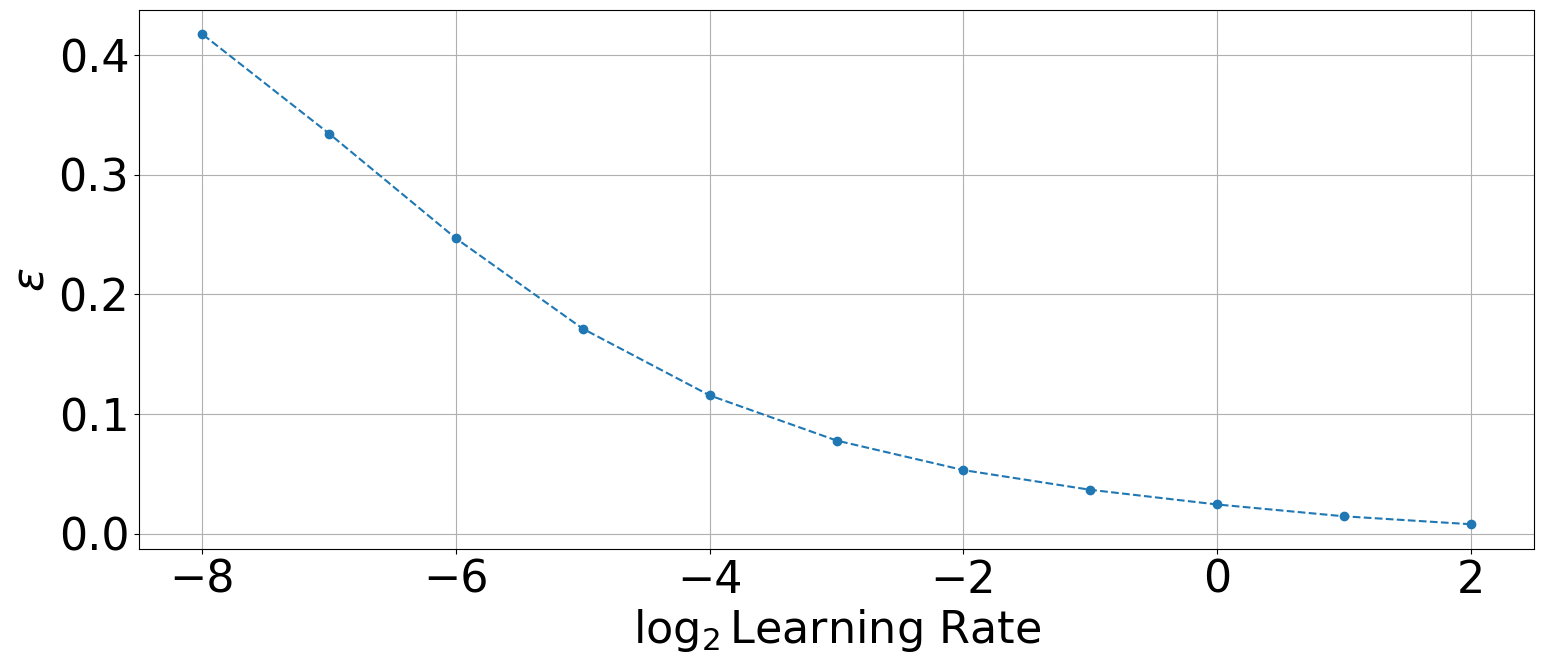

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list), torch.tensor(losses), '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

Next, we tune for the diminishing factor.

In [ ]:
losses = []
for gamma in gamma_list:
    # train a model
    model = Logistic_Regression(input_dim, 1, lam, init_weight, init_intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=2)
    optimizer.zero_grad()
    scheduler = StepLR(optimizer, step_size=100, gamma=gamma)  # Decrease LR by a factor of gamma every dim_step epochs

    for t in range(2000):
        fair_train(tune_GD_data_loader, model, criterion, optimizer)
        scheduler.step()

    loss = fair_test(tune_test_data_loader, model, criterion, lam)

    print(f"diminishing factor: {gamma}\t loss: {loss}")
    losses.append(loss)

diminishing factor: 1.0	 loss: 0.004103022627532482
diminishing factor: 0.99	 loss: 0.004491427447646856
diminishing factor: 0.98	 loss: 0.004902693908661604
diminishing factor: 0.97	 loss: 0.005336062982678413
diminishing factor: 0.96	 loss: 0.005790599621832371
diminishing factor: 0.95	 loss: 0.006265043281018734
diminishing factor: 0.94	 loss: 0.006757938303053379
diminishing factor: 0.9299999999999999	 loss: 0.007267745211720467
diminishing factor: 0.9199999999999999	 loss: 0.007792679592967033
diminishing factor: 0.9099999999999999	 loss: 0.00833088904619217


The plot suggests that the diminishing factor is 1. This is the same as using a constant learning rate.

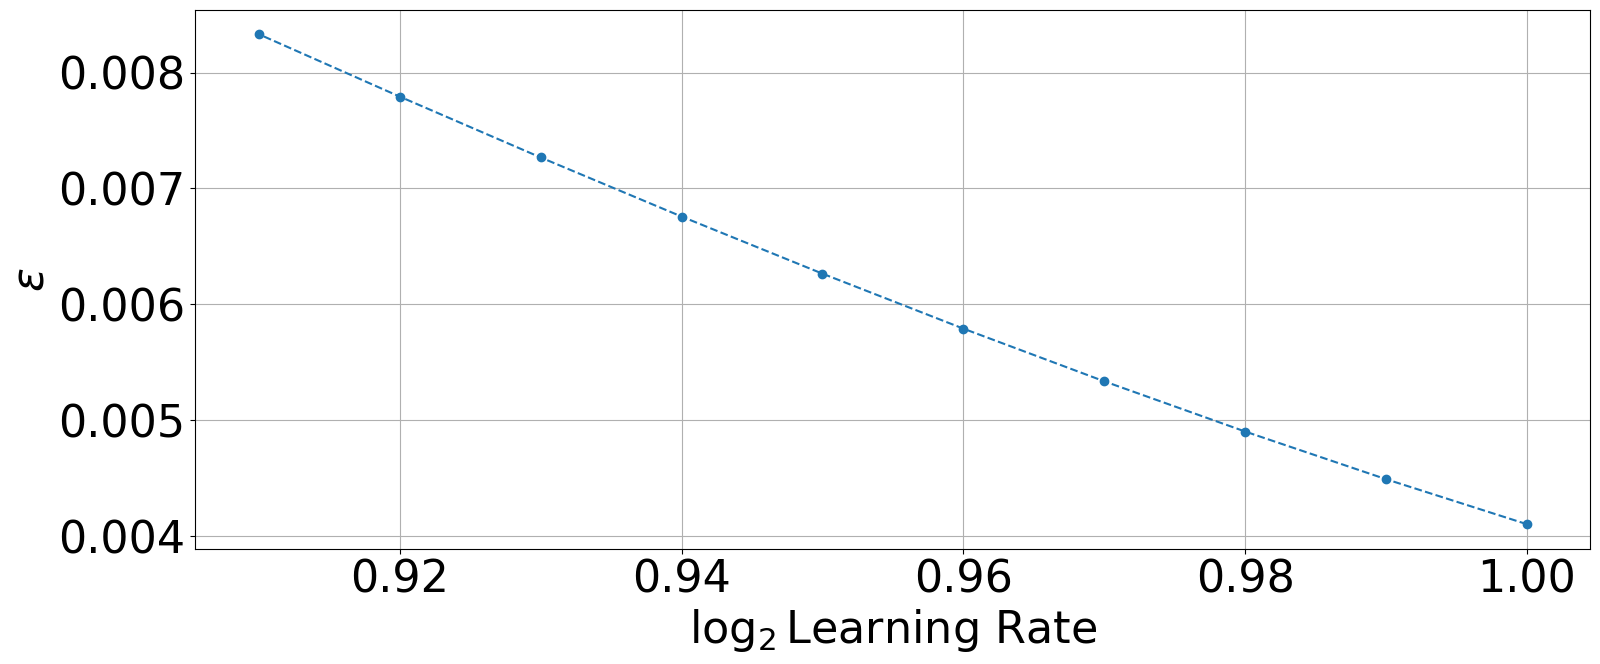

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(gamma_list, torch.tensor(losses), '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [ ]:
losses = []
for alpha in alpha_list:
    # train a model
    model = Logistic_Regression(input_dim, 1, lam, init_weight, init_intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        fair_train(tune_SGD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = fair_test(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 8.0	 loss: 0.046848949044942856
alpha: 4.0	 loss: 0.06304726749658585
alpha: 2.0	 loss: 0.08034971356391907
alpha: 1.0	 loss: 0.10893718898296356
alpha: 0.5	 loss: 0.20565873384475708
alpha: 0.25	 loss: 0.30776363611221313
alpha: 0.125	 loss: 0.423923134803772
alpha: 0.0625	 loss: 0.49944716691970825
alpha: 0.03125	 loss: 0.5370672345161438
alpha: 0.015625	 loss: 0.5703651905059814
alpha: 0.0078125	 loss: 0.6044848561286926


From the plot, we see that $\alpha = 2^3$ gives a low loss stably.

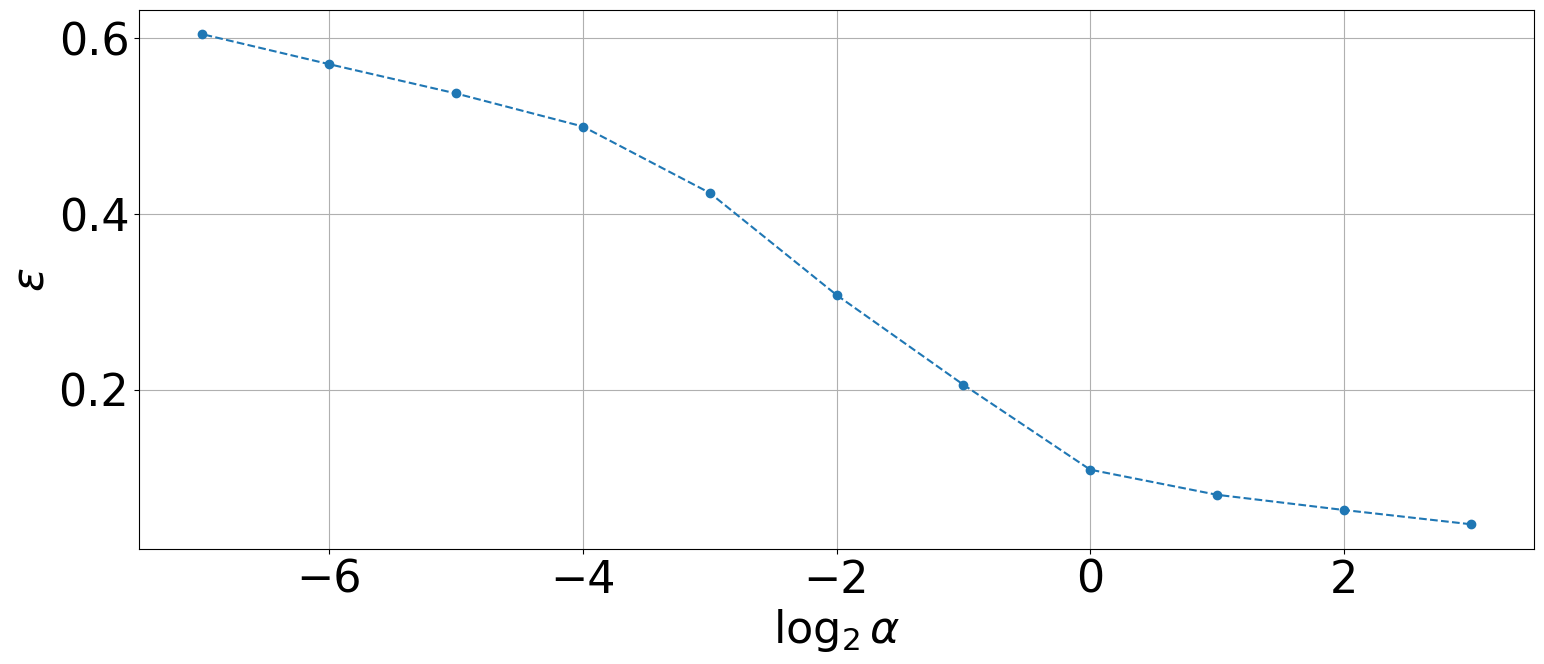

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), losses, '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)